# PROJETO FINAL
INTRODUÇÂO AO PROCESSAMENTO DE IMAGENS


Prof. Bruno Luiggi Macchiavello Espinoza


- Lucas Corrêa Boaventura - 211038262

- Gustavo - 211038235

# Bibliotecas

In [3]:
import numpy as np
from PIL import Image
from IPython.display import display
import cv2
import matplotlib.pyplot as plt

# Sobel



In [106]:
## Função para aplicar o filtro de Sobel
def Sobel(image):
    # Convertendo para escala de cinza
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray,(7,7),0)
    # Aplicando o filtro Sobel nas direções x e y
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
    
    # Calculando a magnitude total do gradiente
    sobel_combined = np.sqrt(sobel_x**2 + sobel_y**2)
    
    # Normalizando para exibir corretamente
    sobel_combined = cv2.convertScaleAbs(sobel_combined)
    
    return sobel_combined

def Canny(image):
    # Converter para escala de cinza
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Aplicar o filtro Canny
    edges = cv2.Canny(gray, 100, 200)
    
    return edges

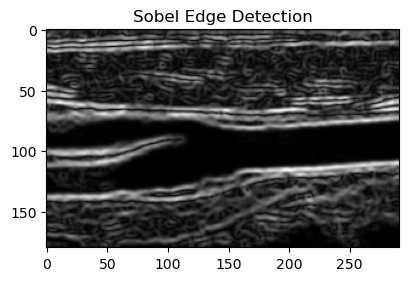

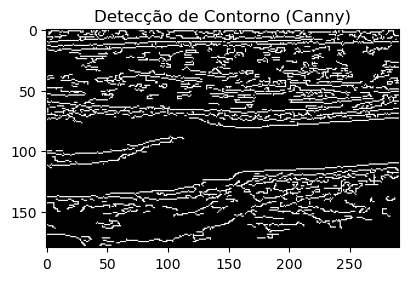

In [107]:
image = cv2.imread('tatiana.png')

# Aplicar o filtro de Sobel
sobel_image = Sobel(image)
canny_image = Canny(image)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(sobel_image, cmap='gray')
plt.title('Sobel Edge Detection')
plt.show()

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 2)
plt.imshow(canny_image, cmap='gray')
plt.title('Detecção de Contorno (Canny)')
plt.show()

In [144]:
# Função para aplicar a detecção de bordas com Laplaciano
def laplacian_edge_detection(image):
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    filtered_image = cv2.Laplacian(image_gray, ksize=3, ddepth=cv2.CV_16S)
    filtered_image = cv2.convertScaleAbs(filtered_image)
    
    
    return filtered_image
    
def post_processing(image):
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))
    
    _, binary = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    closing_image = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)
    opening_image = cv2.morphologyEx(closing_image, cv2.MORPH_OPEN, kernel)
    return opening_image


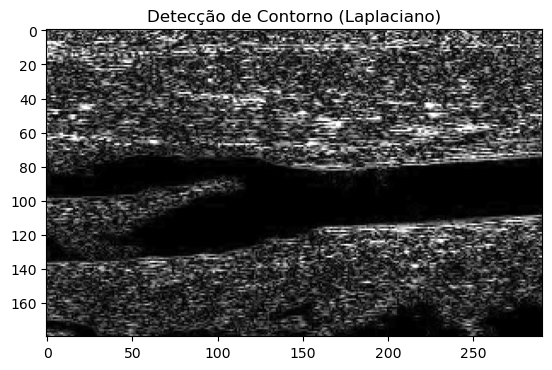

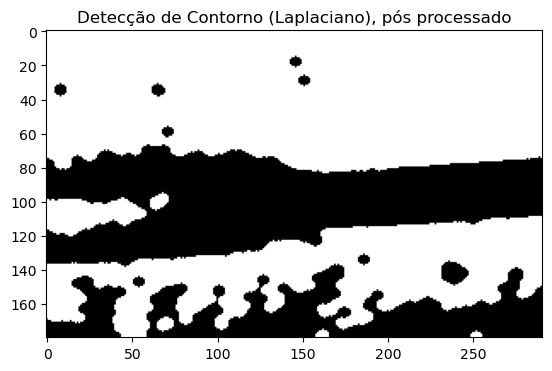

In [145]:


# Carregar a imagem
image = cv2.imread('tatiana.png')

laplacian_image = laplacian_edge_detection(image)
post_laplacian = post_processing(laplacian_image)

plt.imshow(laplacian_image, cmap='gray')
plt.title('Detecção de Contorno (Laplaciano)')
plt.show()

plt.imshow(post_laplacian, cmap='gray')
plt.title('Detecção de Contorno (Laplaciano), pós processado')
plt.show()



In [24]:
from skimage import color, io
from skimage.filters import gaussian
from skimage.segmentation import active_contour

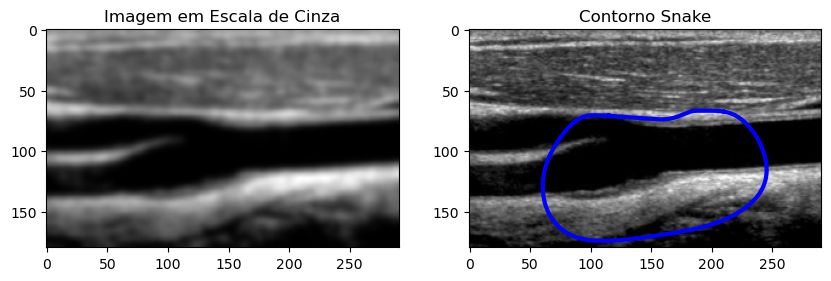

In [70]:
def snake_segmentation(image):
    # Converter a imagem para escala de cinza
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Aplicar uma suavização para remover ruídos
    blurred_image = cv2.GaussianBlur(gray_image, (15, 15), 0)

    # Definir um contorno inicial (círculo) para a evolução da snake
    s = np.linspace(0, 2 * np.pi, 400)
    r = 150 + 100 * np.sin(s)
    c = 150 + 100 * np.cos(s)
    init = np.array([r, c]).T

    # Aplicar o contorno ativo (Snake)
    snake = active_contour(blurred_image, init, def snake_segmentation(image):
    # Converter a imagem para escala de cinza
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Aplicar uma suavização para remover ruídos
    blurred_image = cv2.GaussianBlur(gray_image, (15, 15), 0)

    # Definir um contorno inicial (círculo) para a evolução da snake
    s = np.linspace(0, 2 * np.pi, 400)
    r = 150 + 100 * np.sin(s)
    c = 150 + 100 * np.cos(s)
    init = np.array([r, c]).T

    # Aplicar o contorno ativo (Snake)
    snake = active_contour(blurred_image, init, alpha=0.001, beta=10, gamma=0.001)

    return gray_image, snake, blurred_imagealpha=0.001, beta=10, gamma=0.001)

    return gray_image, snake, blurred_image

# Carregar a imagem
image = io.imread('tatiana.png')

# Aplicar o algoritmo Snake
gray_image, snake_contour, blurred = snake_segmentation(image)

# Mostrar os resultados
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(blurred, cmap='gray')
plt.title('Imagem em Escala de Cinza')

plt.subplot(1, 2, 2)
plt.imshow(gray_image, cmap='gray')
plt.plot(snake_contour[:, 1], snake_contour[:, 0], '-b', lw=3)  # Desenhar o contorno snake
plt.title('Contorno Snake')

plt.show()